### **DATASET SIMULATION**

In [6]:
!pip install sdv

In [ ]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import random

#Fetch Data
url = "https://raw.githubusercontent.com/shrikant-temburwar/Loan-Prediction-Dataset/master/train.csv"
df = pd.read_csv(url)

df = df[['Gender', 'Education', 'Self_Employed', 'ApplicantIncome',
         'CoapplicantIncome', 'LoanAmount', 'Credit_History',
         'Property_Area', 'Loan_Status']]

#Clean
df = df.dropna()
df['Credit_History'] = df['Credit_History'].astype(str)

#Train CTGAN
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
model = CTGANSynthesizer(metadata)
model.fit(df)

#Generate 1000 Synthetic Records
synthetic_data = model.sample(1000)

reasons = [
    "I need to renovate my house immediately.",
    "Planning to expand my small business operations.",
    "Urgent medical expenses covered by loan.",
    "Buying a new car for daily commute.",
    "Consolidating high-interest debts.",
    "Investment in a new startup opportunity."
]

qualifiers = [
    "I am very confident in repayment.",
    "I might struggle slightly initially.",
    "Business is booming right now.",
    "Facing some financial stress currently."
]

def generate_text(row):
    reason = random.choice(reasons)
    if row['ApplicantIncome'] > 10000:
        qualifier = "I am very confident in repayment."
    else:
        qualifier = random.choice(qualifiers)
    return f"{reason} {qualifier}"

synthetic_data['Application_Note'] = synthetic_data.apply(generate_text, axis=1)

#Save
print(synthetic_data.head())
synthetic_data.to_csv('synthetic_financial_data_enhanced.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


   Gender     Education Self_Employed  ApplicantIncome  CoapplicantIncome  \
0    Male      Graduate            No             1969           0.000000   
1    Male  Not Graduate            No             1544           0.000000   
2    Male      Graduate            No              388         345.682079   
3    Male  Not Graduate           Yes              150         145.880326   
4  Female      Graduate           Yes             1691          32.047091   

   LoanAmount Credit_History Property_Area Loan_Status  \
0       247.0            0.0         Rural           N   
1       268.0            1.0     Semiurban           Y   
2       121.0            1.0     Semiurban           Y   
3       216.0            1.0     Semiurban           Y   
4       103.0            1.0         Rural           N   

                                    Application_Note  
0  Urgent medical expenses covered by loan. Facin...  
1  Urgent medical expenses covered by loan. Busin...  
2  Buying a new car for

In [8]:
# Load the dataset
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('C:\\Users\\User\\Documents\\VisualStudioCode\\Data Mining Assignment\\DataMining_GP1\\synthetic_financial_data_enhanced.csv')

# Check for missing values
missing_summary = data.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)


Missing Values Summary:
Gender               0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Credit_History       0
Property_Area        0
Loan_Status          0
Application_Note     0
dtype: int64


### **FEATURE ENGINEERING**

In [ ]:
categorical_cols = [
    'Gender', 'Education', 'Self_Employed',
    'Property_Area', 'Loan_Status'
]

df[categorical_cols] = df[categorical_cols].astype(object)

In [ ]:
# Total household income
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Loan to income ratio (add 1 to avoid division by zero)
df['LoanIncomeRatio'] = df['LoanAmount'] / (df['TotalIncome'] + 1)

In [ ]:
df['HasCreditHistory'] = df['Credit_History'].apply(
    lambda x: 1 if x == 1 else 0
)

In [ ]:
df['Employment_Type'] = df['Self_Employed'].map({
    'Yes': 'Self_Employed',
    'No': 'Salaried'
})

In [ ]:
df['IncomeLevel'] = pd.cut(
    df['TotalIncome'],
    bins=[0, 2000, 5000, 10000, df['TotalIncome'].max()],
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [ ]:
df['Note_Length'] = df['Application_Note'].str.len()

# Risk keyword flag
risk_keywords = ['urgent', 'debt', 'medical', 'delay', 'struggle']

df['Risk_Keyword_Flag'] = df['Application_Note'].str.lower().apply(
    lambda x: 1 if any(word in x for word in risk_keywords) else 0
)

In [ ]:
encode_cols = [
    'Gender', 'Education', 'Employment_Type',
    'Property_Area', 'IncomeLevel'
]

df_model = pd.get_dummies(df, columns=encode_cols, drop_first=True)

print("Final feature set shape:", df_model.shape)
df_model.head()

Final feature set shape: (1000, 20)


,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Application_Note,TotalIncome,LoanIncomeRatio,HasCreditHistory,Note_Length,Risk_Keyword_Flag,Gender_Male,Education_Not Graduate,Employment_Type_Self_Employed,Property_Area_Semiurban,Property_Area_Urban,IncomeLevel_Medium,IncomeLevel_High,IncomeLevel_Very High
0,No,1969,0.000000,247.0,0.0,N,Urgent medical expenses covered by loan. Facin...,1969.000000,0.125381,0,80,1,True,False,False,False,False,False,False,False
1,No,1544,0.000000,268.0,1.0,Y,Urgent medical expenses covered by loan. Busin...,1544.000000,0.173463,1,71,1,True,True,False,True,False,False,False,False
2,No,388,345.682079,121.0,1.0,Y,Buying a new car for daily commute. I might st...,733.682079,0.164697,1,72,1,True,False,False,True,False,False,False,False
3,Yes,150,145.880326,216.0,1.0,Y,I need to renovate my house immediately. Facin...,295.880326,0.727566,1,80,0,True,True,True,True,False,False,False,False
4,Yes,1691,32.047091,103.0,1.0,N,Planning to expand my small business operation...,1723.047091,0.059743,1,88,0,False,False,True,False,False,False,False,False


In [ ]:
df_model.to_csv("synthetic_financial_data_feature_engineered.csv", index=False)
print("Feature-engineered dataset saved successfully.")

Feature-engineered dataset saved successfully.


In [ ]:
import pandas as pd
raw_df = pd.read_csv("synthetic_financial_data_feature_engineered.csv")

# Check for redundancy/multicollinearity
# Self_Employed and Employment_Type_Self_Employed
# Credit_History and HasCreditHistory
redundancy_check_1 = pd.crosstab(raw_df['Self_Employed'], raw_df['Employment_Type_Self_Employed'])
redundancy_check_2 = pd.crosstab(raw_df['Credit_History'], raw_df['HasCreditHistory'])
print("\nRedundancy Check (Self_Employed vs Employment_Type):")
print(redundancy_check_1)
print("\nRedundancy Check (Credit_History vs HasCreditHistory):")
print(redundancy_check_2)


Redundancy Check (Self_Employed vs Employment_Type):
Employment_Type_Self_Employed  False  True 
Self_Employed                              
No                               817      0
Yes                                0    183

Redundancy Check (Credit_History vs HasCreditHistory):
HasCreditHistory    0    1
Credit_History            
0.0               198    0
1.0                 0  802


In [ ]:
# Drop redundant columns
cols_to_drop = ['Self_Employed', 'Credit_History']
check_df = raw_df.drop(columns=cols_to_drop)

In [ ]:
import numpy as np

# 1. Row count check
print(f"Rows: {len(check_df)} / 1000")

# 2. Check Empty cells
print(f"Empty cells: {check_df.isnull().sum().sum()}")

# 3. Check math errors
inf_errors = np.isinf(check_df['LoanIncomeRatio']).sum()
print(f"Math errors (Infinity): {inf_errors}")

Rows: 1000 / 1000
Empty cells: 0
Math errors (Infinity): 0


In [ ]:
check_df.to_csv('final_synthetic_financial_data_feature_engineered.csv', index=False)

### **EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

eda_df = pd.read_csv("final_synthetic_financial_data_feature_engineered.csv")

# EDA1: Data Structure
print("Data Structure")
print("\nDataFrame Info:")
print(eda_df.info())

In [5]:
continuous_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'LoanIncomeRatio', 'Note_Length']
binary_cols = ['HasCreditHistory', 'Risk_Keyword_Flag', 'Gender_Male', 'Education_Not Graduate', 
               'Employment_Type_Self_Employed', 'Property_Area_Semiurban', 'Property_Area_Urban', 
               'IncomeLevel_Medium', 'IncomeLevel_High', 'IncomeLevel_Very High','Loan_Status']
               
print("\nNumerical Description:")
num_desc = eda_df[continuous_cols].describe().T
print(num_desc)

print("\nCategorical Description:")
binary_summary = []
for col in binary_cols:
    if col == 'Loan_Status':
        count_y = (eda_df[col] == 'Y').sum()
        pct_y = (count_y / len(eda_df)) * 100
        binary_summary.append({'Feature': col, 'Condition': 'Approved (Y)', 'Count': count_y, 'Percentage': f"{pct_y:.2f}%"})
    else:
        # For bool and 1/0 int
        count_true = (eda_df[col].astype(int) == 1).sum()
        pct_true = (count_true / len(eda_df)) * 100
        binary_summary.append({'Feature': col, 'Condition': 'True / 1', 'Count': count_true, 'Percentage': f"{pct_true:.2f}%"})

binary_summary_df = pd.DataFrame(binary_summary)
print(binary_summary_df)

eda_df.select_dtypes(include='object').nunique()


Numerical Description:
                    count         mean          std         min         25%  \
ApplicantIncome    1000.0  2554.232000  2936.458800  150.000000  311.750000   
CoapplicantIncome  1000.0   441.228062  1182.197706    0.000000    0.000000   
LoanAmount         1000.0   197.026000    95.533554    9.000000  137.750000   
TotalIncome        1000.0  2995.460062  3143.150891  150.000000  638.750000   
LoanIncomeRatio    1000.0     0.309767     0.489510    0.000553    0.038174   
Note_Length        1000.0    74.695000     5.629713   65.000000   71.000000   

                           50%          75%           max  
ApplicantIncome    1525.000000  3562.000000  17790.000000  
CoapplicantIncome     0.000000   201.131363  10742.129190  
LoanAmount          190.000000   241.000000    600.000000  
TotalIncome        2079.639129  4192.919304  19134.122329  
LoanIncomeRatio       0.085863     0.308534      3.973510  
Note_Length          74.000000    79.000000     88.000000  

C

Loan_Status          2
Application_Note    24
dtype: int64


Target Distribution:


/tmp/ipykernel_2056/4033433614.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Loan_Status', data=eda_df, palette={'Y': '#4CAF50', 'N': '#F44336'})


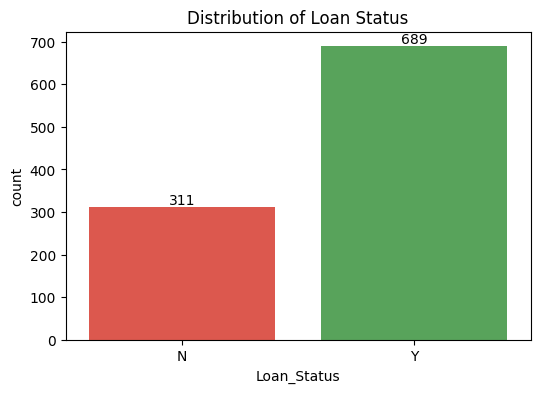


Categorical Distribution:


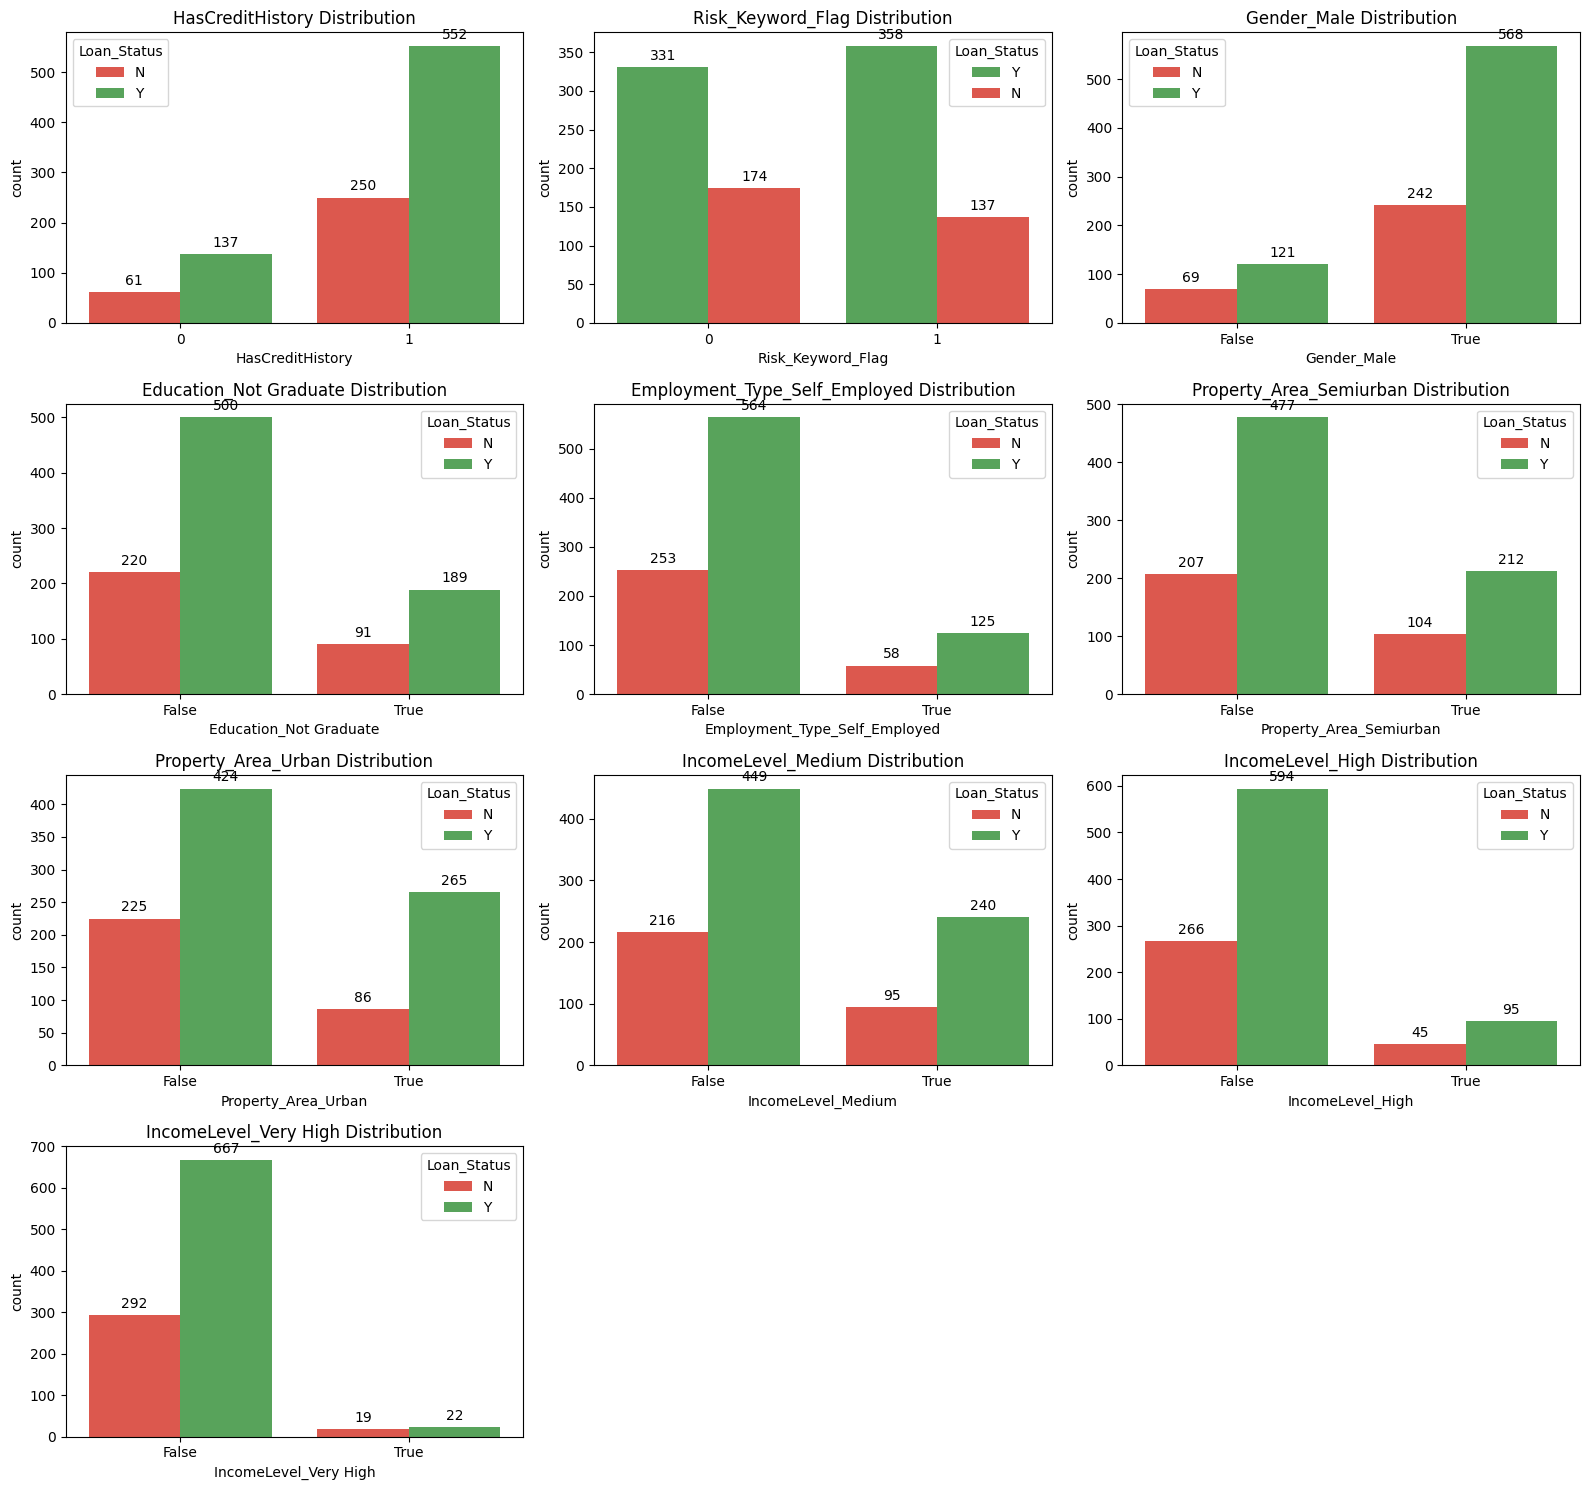


Categorical Approval Rates:


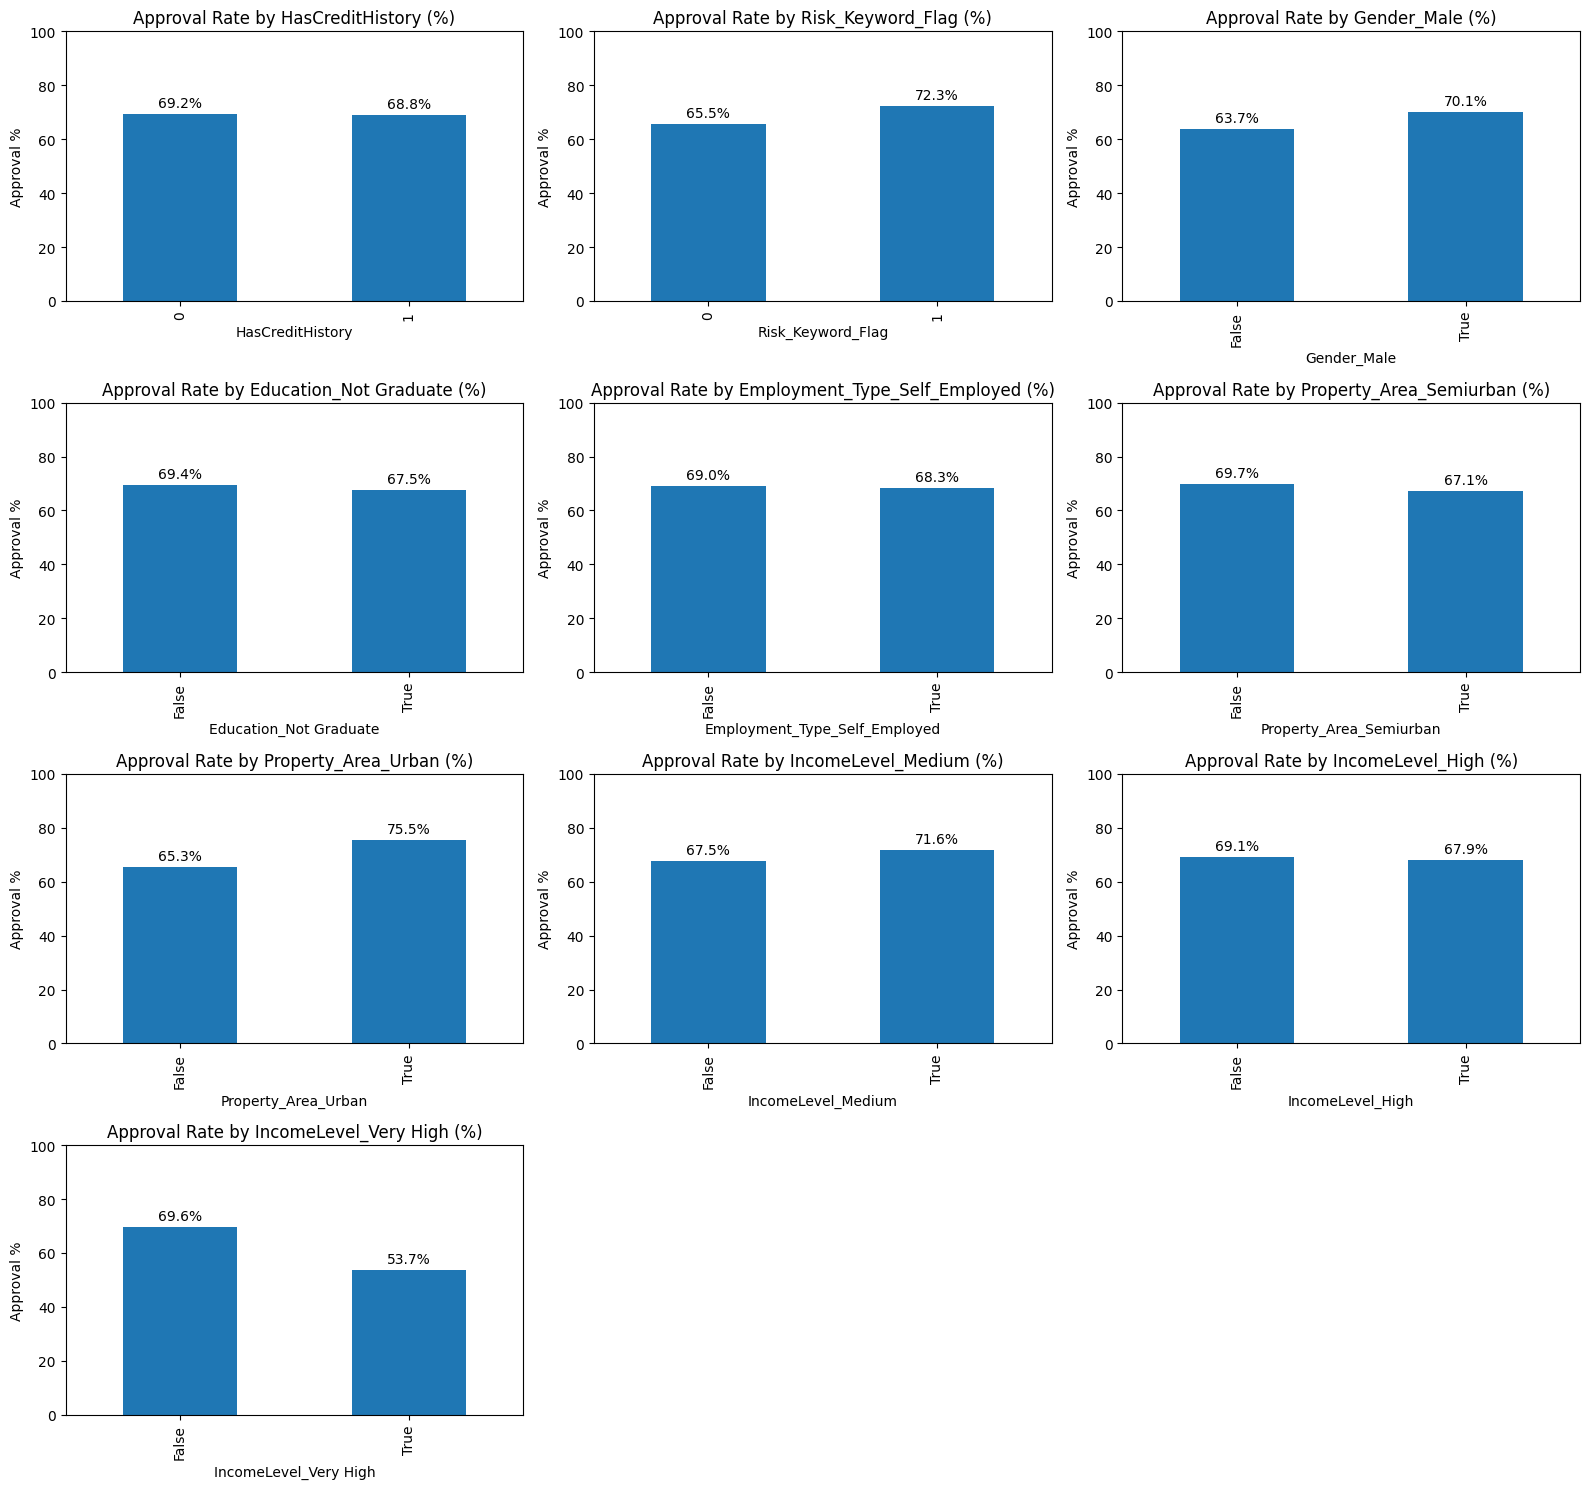


Outlier Detection


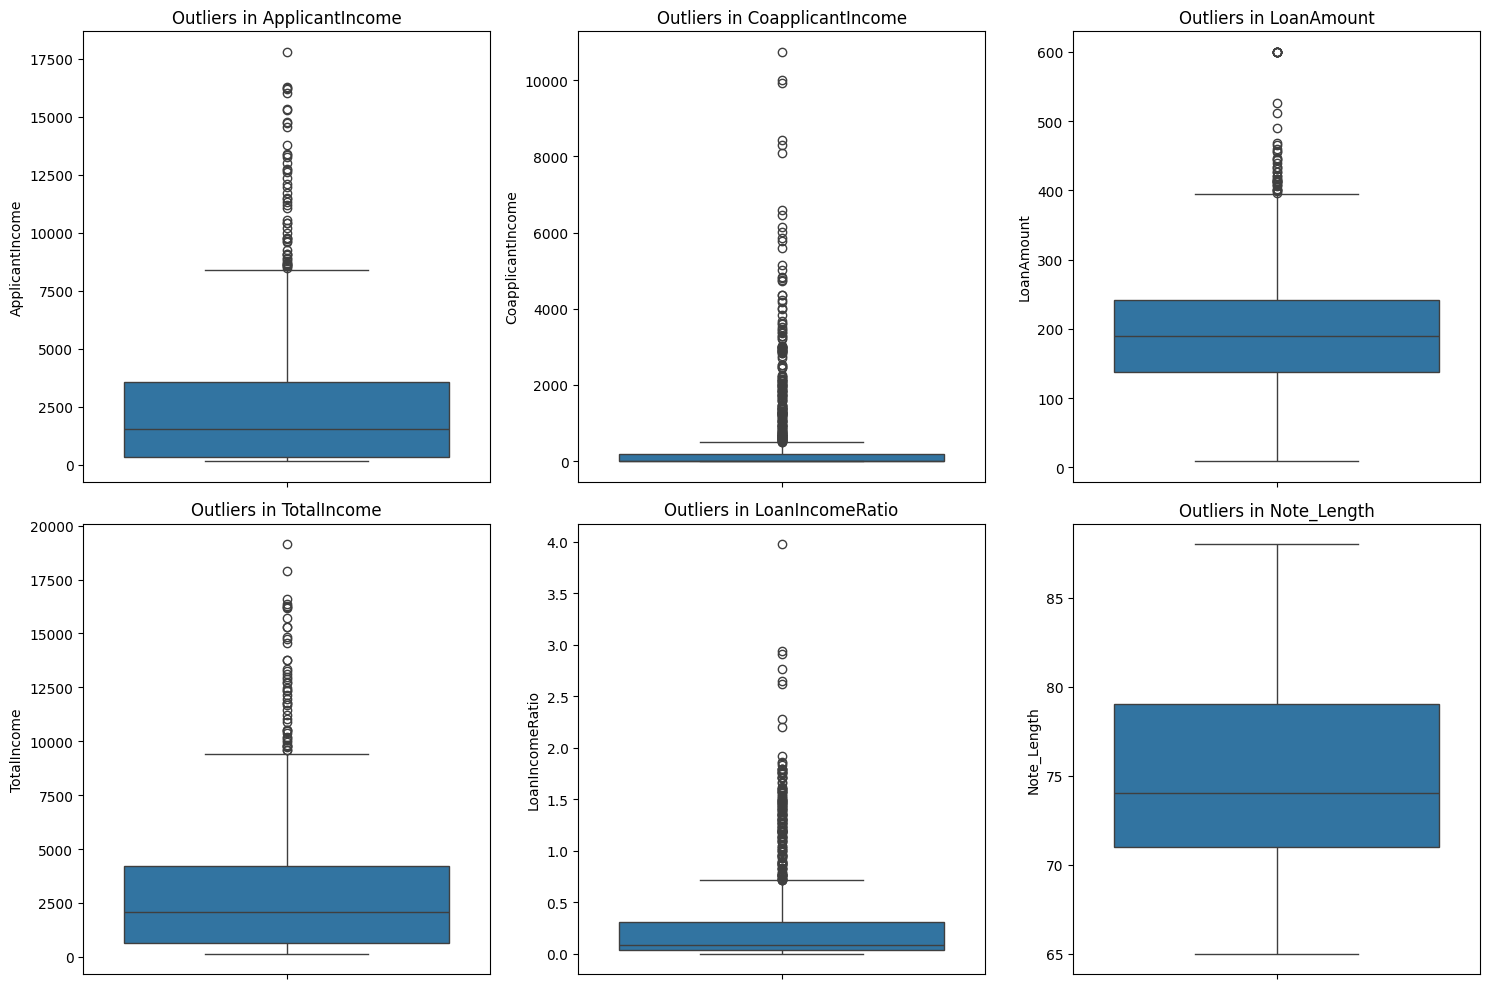


Numerical Distribution:


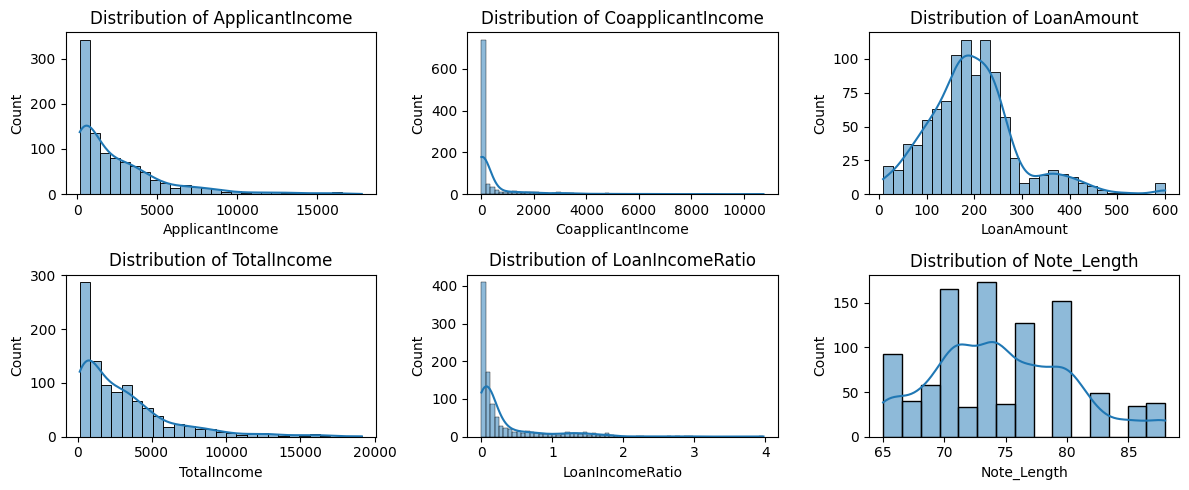

/tmp/ipykernel_2056/4033433614.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Loan_Status', y=col, data=eda_df, inner='quart', palette={'Y': '#4CAF50', 'N': '#F44336'})
/tmp/ipykernel_2056/4033433614.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Loan_Status', y=col, data=eda_df, inner='quart', palette={'Y': '#4CAF50', 'N': '#F44336'})
/tmp/ipykernel_2056/4033433614.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Loan_Status', y=col, data=eda_df, inner='quart', palette={'Y': '#4CAF50', 'N': '#F44336'})


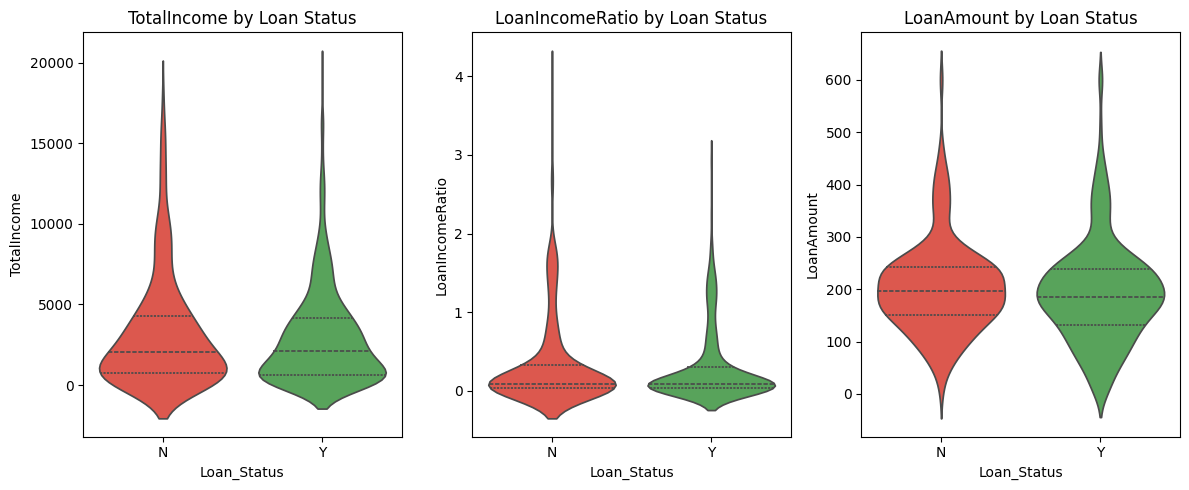

In [6]:
# EDA2: Distribution and Target vs Features
# Target Distribution
print("\nTarget Distribution:")
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=eda_df, palette={'Y': '#4CAF50', 'N': '#F44336'})
for container in plt.gca().containers:
    plt.gca().bar_label(container)
plt.title('Distribution of Loan Status')
plt.show()

# Categorical Distribution
print("\nCategorical Distribution:")
plt.figure(figsize=(16, 15))
cat_plot_cols = ['HasCreditHistory', 'Risk_Keyword_Flag', 'Gender_Male', 'Education_Not Graduate',
               'Employment_Type_Self_Employed', 'Property_Area_Semiurban', 'Property_Area_Urban',
               'IncomeLevel_Medium', 'IncomeLevel_High', 'IncomeLevel_Very High']
for i, col in enumerate(cat_plot_cols):
    plt.subplot(4, 3, i+1)
    sns.countplot(data=eda_df, x=col, hue='Loan_Status',palette={'Y': '#4CAF50', 'N': '#F44336'})
    for container in plt.gca().containers:
        plt.gca().bar_label(container, padding=3)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

eda_df['Loan_Status_Num'] = eda_df['Loan_Status'].map({'Y': 1, 'N': 0})

# Categorical Approval Rates (%)
print("\nCategorical Approval Rates:")
plt.figure(figsize=(16, 15))
for i, col in enumerate(cat_plot_cols):
    plt.subplot(4, 3, i+1)
    app_rate = eda_df.groupby(col)['Loan_Status_Num'].mean() * 100
    app_rate.plot(kind='bar')
    for container in plt.gca().containers:
        plt.gca().bar_label(container, fmt='%.1f%%', padding=3)
    plt.title(f'Approval Rate by {col} (%)')
    plt.ylabel('Approval %')
    plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Outlier Detection for Continuous Features
print("\nOutlier Detection")
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=eda_df[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

# Numerical Distribution
print("\nNumerical Distribution:")
plt.figure(figsize=(12, 5))
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(eda_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

key_features = ['TotalIncome', 'LoanIncomeRatio', 'LoanAmount']

plt.figure(figsize=(12, 5))
for i, col in enumerate(key_features):
    plt.subplot(1, 3, i+1)
    sns.violinplot(x='Loan_Status', y=col, data=eda_df, inner='quart', palette={'Y': '#4CAF50', 'N': '#F44336'})
    plt.title(f'{col} by Loan Status')
plt.tight_layout()
plt.show()

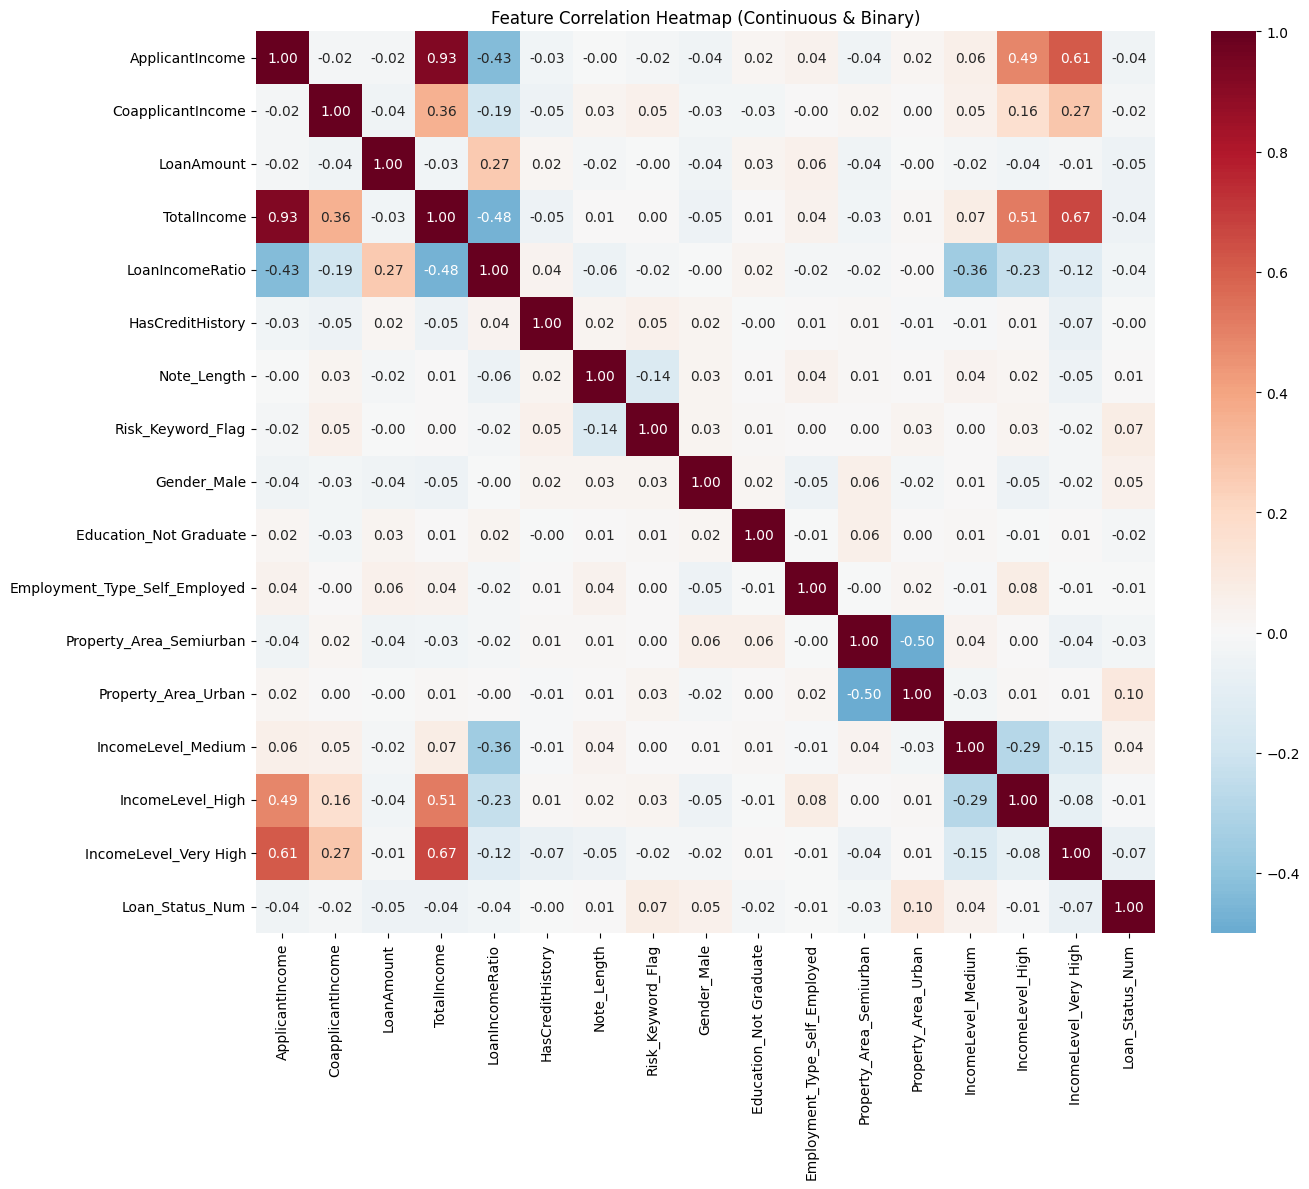

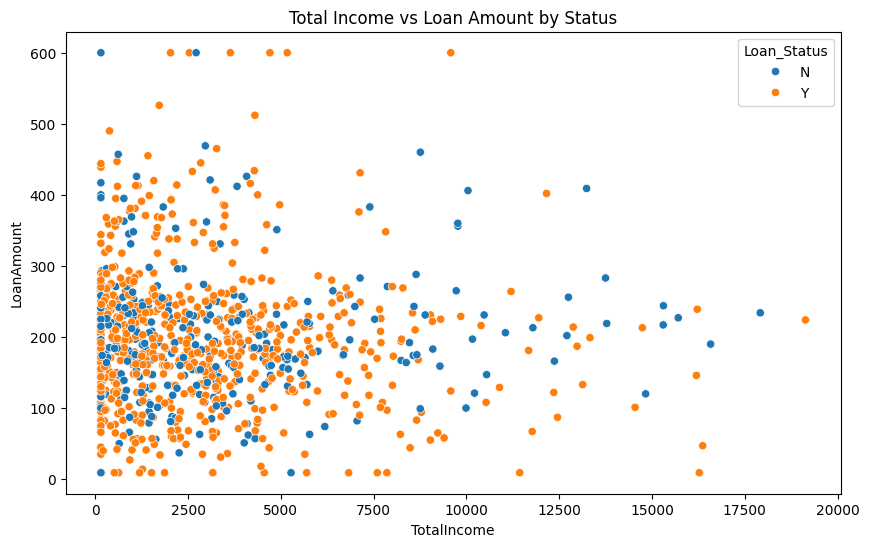

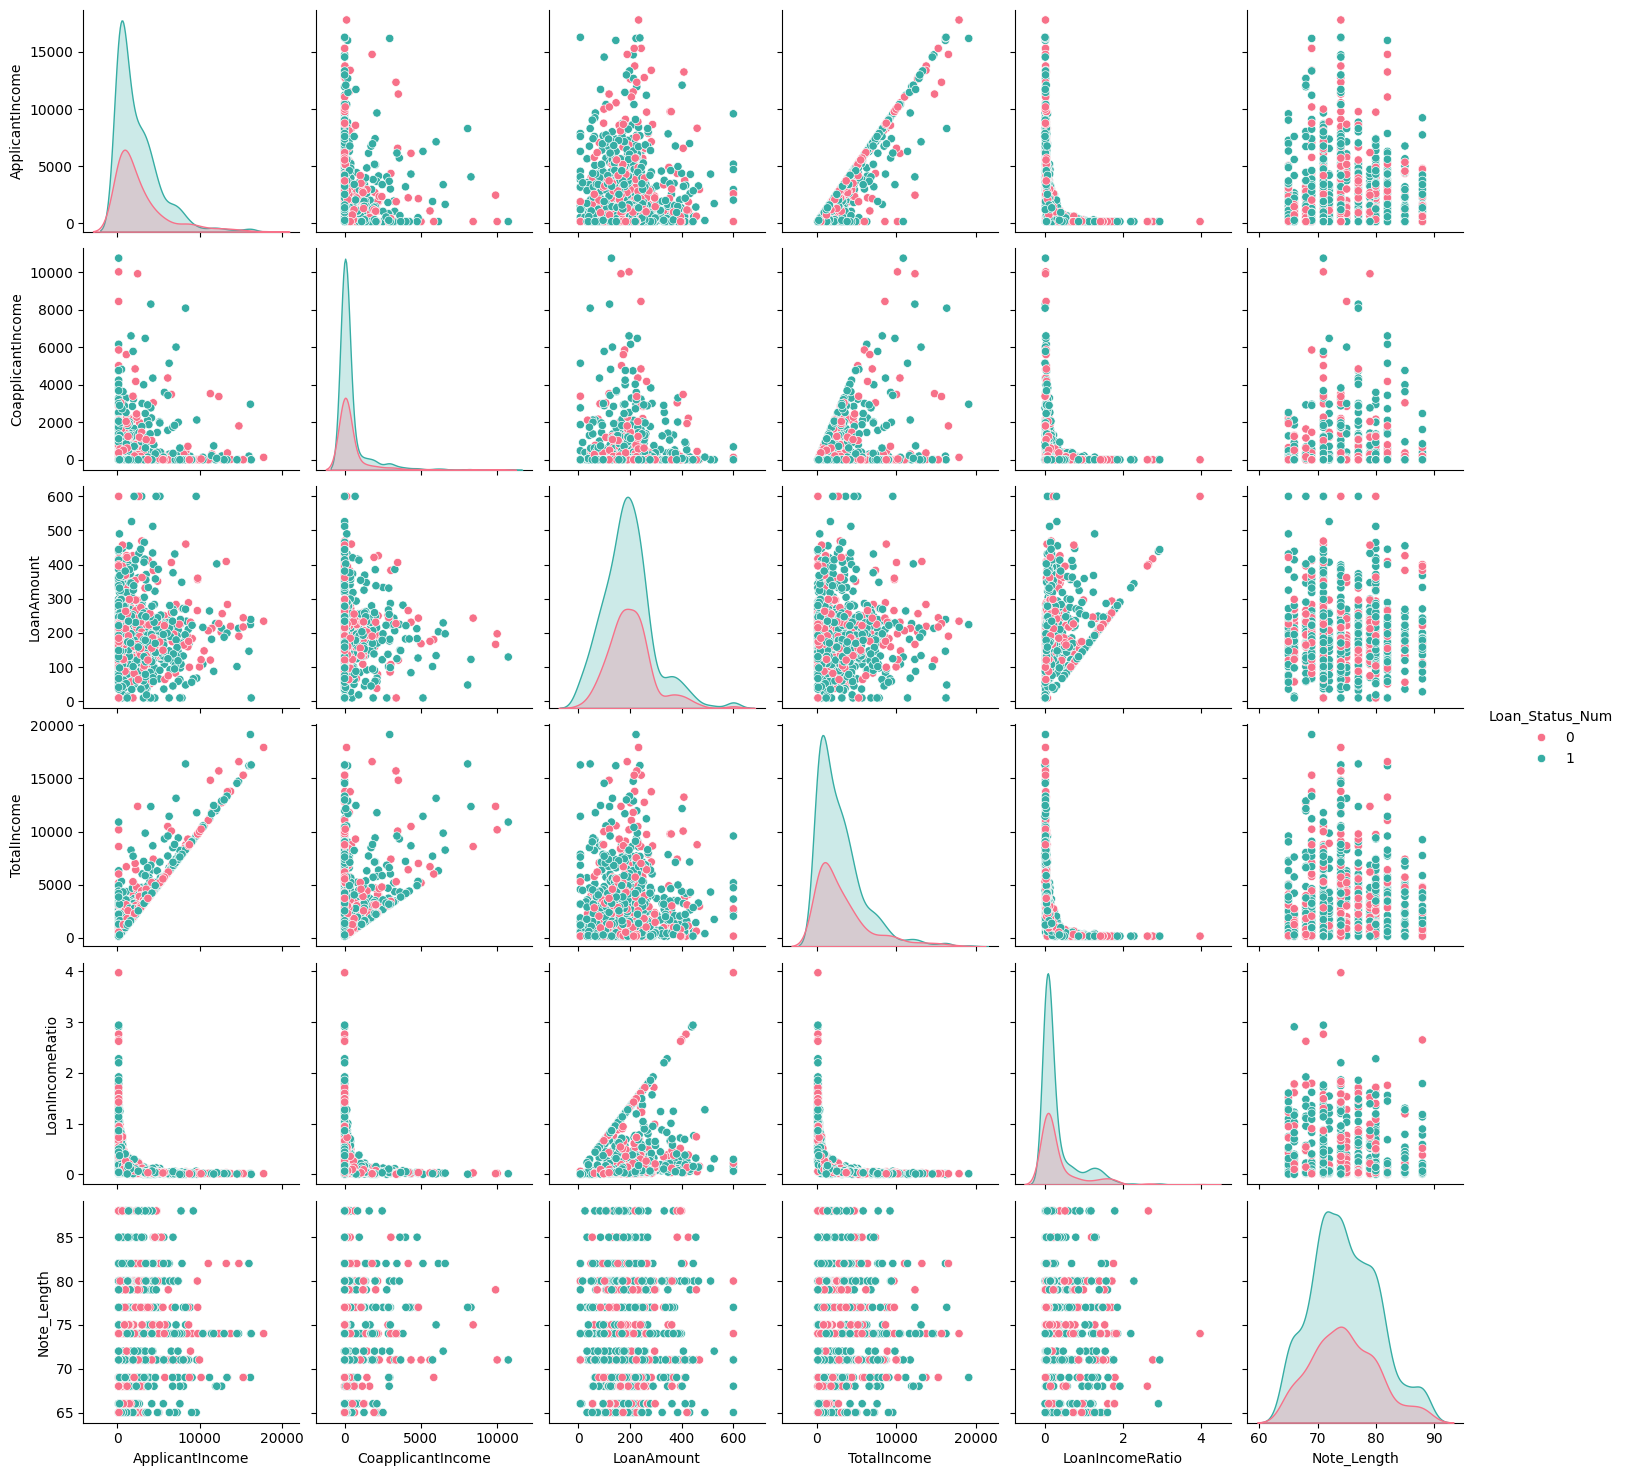

In [7]:
# EDA 3: CORRELATION & MULTIVARIATE
import numpy as np

numeric_df = eda_df.select_dtypes(include=[np.number, 'bool']).copy()
for col in numeric_df.select_dtypes(include=['bool']).columns:
    numeric_df[col] = numeric_df[col].astype(int)

# 1. Heatmap (Includes all Numeric and Binary Flags)
plt.figure(figsize=(14, 12))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Feature Correlation Heatmap (Continuous & Binary)')
plt.tight_layout()
plt.show()

# 2. Multivariate Scatter: Income vs Loan Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=eda_df, x='TotalIncome', y='LoanAmount', hue='Loan_Status')
plt.title('Total Income vs Loan Amount by Status')
plt.show()

# 3. Pairplot for ALL continuous numerical columns + Target
pair_features = continuous_cols + ['Loan_Status_Num']
sns.pairplot(eda_df[pair_features], hue='Loan_Status_Num', diag_kind='kde', palette='husl')
plt.show()

**EDA Insights Summary:**

*  The dataset contains 1,000 individual loan applications described by 18 different variables. Financially, the applicants' personal income ranges widely from 150 to 17,790, with an average of about 2,554. When we combine this with co-applicant earnings, the average Total Household Income rises to 2,995. We also looked at the LoanIncomeRatio, which averages 0.31, meaning most people are asking for loans worth about 31% of their income. Demographic data shows the group is 81% male, 80.2% have a known credit history, 28% are not college graduates and 18.3% are self-employed. We also analyzed the application notes, which range from 65 to 88 characters in length.

*  The target is the Loan Status which shows that 68.9% of applications were approved, while 31.1% were rejected. When looking at the distributions, we see many outliers in the income and loan amount columns. For instance, while the median household income is 2,079, some people earn over 19,000. There are outliers in all the continuous features (except for Note_Length). However, it is okay to not remove these outliers because they represent real-world data such as wealthy customers and aggresive loaners, it is not mistakes in the data. Thus, keeping them helps the model understand high-value and different variety of clients.

*  A key insight is that while more income usually helps, the Very High income group actually has a lower approval rate (53.7%) than average. This suggests that these wealthy individuals might be requesting riskier loans that the bank is more cautious about approving. On the other hand, Property_Area_Urban applicants show a higher than average approval rate of 75.5%, marking it as a strong positive indicator. Finally, We found that there is a very strong correlation (0.93) between ApplicantIncome and TotalIncome which means they are almost the same thing (highly redundant), so we should likely only use one of them in the modeling to avoid multicollinearity.

In [3]:
import pandas as pd

df = pd.read_csv("C:\\Users\\User\\Documents\\VisualStudioCode\\Data Mining Assignment\\DataMining_GP1\\final_synthetic_financial_data_feature_engineered.csv")


In [11]:
!pip install seaborn

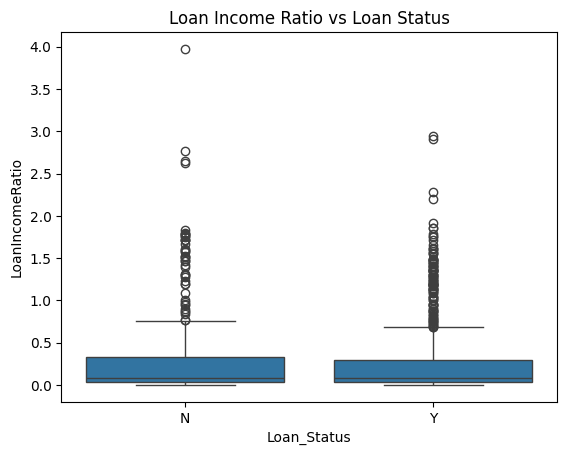

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Loan_Status', y='LoanIncomeRatio', data=df)
plt.title("Loan Income Ratio vs Loan Status")
plt.show()


The boxplot shows that applicants with lower loan-to-income ratios are more likely to have their loans approved. Rejected applications tend to exhibit higher variability and extreme values, indicating that repayment capacity plays an important role in loan approval decisions.

### **FEATURE IMPORTANCE ANALYSIS**
Using Random Forest to determine feature importance for Loan_Status prediction.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
# Drop non-numeric columns for modeling
X = df.drop(columns=['Loan_Status', 'Application_Note'])
y = df['Loan_Status']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Y=1, N=0

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  Y (Approved): {sum(y_encoded)} ({sum(y_encoded)/len(y_encoded)*100:.1f}%)")
print(f"  N (Rejected): {len(y_encoded) - sum(y_encoded)} ({(len(y_encoded) - sum(y_encoded))/len(y_encoded)*100:.1f}%)")

Features shape: (1000, 16)
Target distribution:
  Y (Approved): 689 (68.9%)
  N (Rejected): 311 (31.1%)


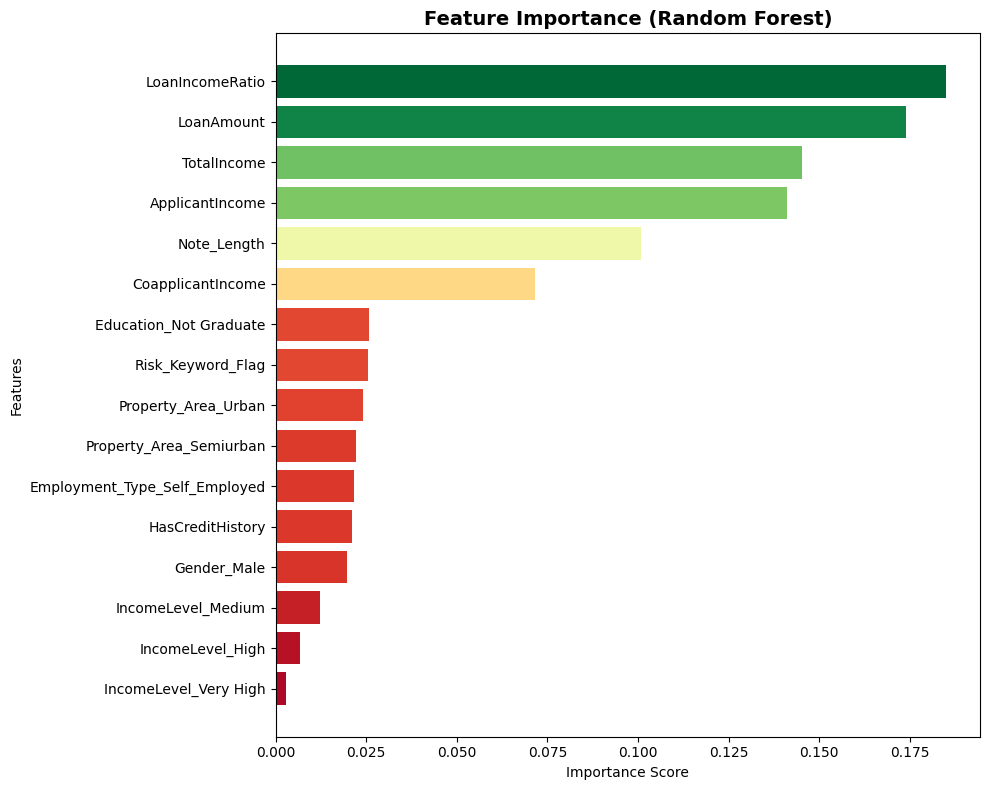


Top 10 Most Important Features:
                feature  importance
Property_Area_Semiurban    0.022326
    Property_Area_Urban    0.024269
      Risk_Keyword_Flag    0.025397
 Education_Not Graduate    0.025755
      CoapplicantIncome    0.071525
            Note_Length    0.100846
        ApplicantIncome    0.141041
            TotalIncome    0.145141
             LoanAmount    0.173930
        LoanIncomeRatio    0.185127


In [14]:
# Feature Importance using Random Forest
# Using class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X, y_encoded)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
colors = plt.cm.RdYlGn(importance_df['importance'] / importance_df['importance'].max())
plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display top features
print("\nTop 10 Most Important Features:")
print(importance_df.tail(10).to_string(index=False))

### **FEATURE SELECTION**
Selecting features based on importance scores. Features with importance > mean importance are selected.

In [15]:
# Feature Selection based on importance threshold
importance_threshold = importance_df['importance'].mean()
print(f"Mean importance: {importance_threshold:.4f}")

# Select features above threshold
selected_features = importance_df[importance_df['importance'] > importance_threshold]['feature'].tolist()
print(f"\nSelected {len(selected_features)} features (above mean importance):")
for i, feat in enumerate(selected_features, 1):
    importance_val = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"  {i}. {feat}: {importance_val:.4f}")

# Create selected feature matrix
X_selected = X[selected_features]
print(f"\nSelected features shape: {X_selected.shape}")

Mean importance: 0.0625

Selected 6 features (above mean importance):
  1. CoapplicantIncome: 0.0715
  2. Note_Length: 0.1008
  3. ApplicantIncome: 0.1410
  4. TotalIncome: 0.1451
  5. LoanAmount: 0.1739
  6. LoanIncomeRatio: 0.1851

Selected features shape: (1000, 6)


### **PREDICTIVE MODEL DEVELOPMENT**

In [16]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_selected, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Second split: 50% of temp for val, 50% for test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Data Split Summary:")
print(f"  Training:   {len(X_train):4d} samples ({len(X_train)/len(X_selected)*100:.1f}%)")
print(f"  Validation: {len(X_val):4d} samples ({len(X_val)/len(X_selected)*100:.1f}%)")
print(f"  Test:       {len(X_test):4d} samples ({len(X_test)/len(X_selected)*100:.1f}%)")

print(f"\nClass Distribution (Y=Approved, N=Rejected):")
print(f"  Training:   Y={sum(y_train)}, N={len(y_train)-sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}% approved)")
print(f"  Validation: Y={sum(y_val)}, N={len(y_val)-sum(y_val)} ({sum(y_val)/len(y_val)*100:.1f}% approved)")
print(f"  Test:       Y={sum(y_test)}, N={len(y_test)-sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}% approved)")

Data Split Summary:
  Training:    700 samples (70.0%)
  Validation:  150 samples (15.0%)
  Test:        150 samples (15.0%)

Class Distribution (Y=Approved, N=Rejected):
  Training:   Y=482, N=218 (68.9% approved)
  Validation: Y=103, N=47 (68.7% approved)
  Test:       Y=104, N=46 (69.3% approved)


### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')

# Define hyperparameter search space
param_dist = {
    'C': loguniform(1e-3, 1e3),           # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],               # Regularization type
    'solver': ['liblinear', 'saga'],       # Solvers supporting L1/L2
    'max_iter': [100, 200, 500, 1000],
    'class_weight': ['balanced', None]     # Handle class imbalance
}

# Initialize Logistic Regression
lr = LogisticRegression(random_state=42)

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    lr,
    param_dist,
    n_iter=20,               # Number of random combinations to try
    cv=5,                     # 5-fold cross-validation
    scoring='f1',             # Optimize for F1-score
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train)

lr_model = random_search.best_estimator_ 

print(f"\n{'='*50}")
print("Best Hyperparameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest Cross-Validation F1 Score: {random_search.best_score_:.4f}")

Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters Found:
  C: 0.002231010801867922
  class_weight: None
  max_iter: 100
  penalty: l2
  solver: saga

Best Cross-Validation F1 Score: 0.8156


### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Baseline Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train on the Training Set
print("Training Baseline Random Forest")
rf_baseline.fit(X_train, y_train)

# Quick Check on Validation Set
val_preds = rf_baseline.predict(X_val)
print(f"Baseline Validation F1 Score: {f1_score(y_val, val_preds):.4f}")
print("\nBaseline Validation Report:")
print(classification_report(y_val, val_preds))

Training Baseline Random Forest
Baseline Validation F1 Score: 0.7932

Baseline Validation Report:
              precision    recall  f1-score   support

           0       0.44      0.15      0.22        47
           1       0.70      0.91      0.79       103

    accuracy                           0.67       150
   macro avg       0.57      0.53      0.51       150
weighted avg       0.62      0.67      0.61       150



In [19]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define Search Space
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Search
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search_rf = RandomizedSearchCV(
    estimator=rf_tuned,
    param_distributions=rf_params,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting Hyperparameter Tuning...")
random_search_rf.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(random_search_rf.best_params_)

# Show mean vs std deviation (Stability check)
# If std_dev is high (>0.05), the model might be unstable
mean_score = random_search_rf.best_score_
std_dev = random_search_rf.cv_results_['std_test_score'][random_search_rf.best_index_]

print(f"\nBest CV F1 Score: {mean_score:.4f} (+/- {std_dev:.4f})")

if std_dev > 0.05:
    print("WARNING: Model performance varies significantly between folds.")
else:
    print("Model performance is stable across folds.")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': None, 'bootstrap': True}

Best CV F1 Score: 0.7928 (+/- 0.0124)
Model performance is stable across folds.


Tuned Model Validation F1 Score: 0.8148


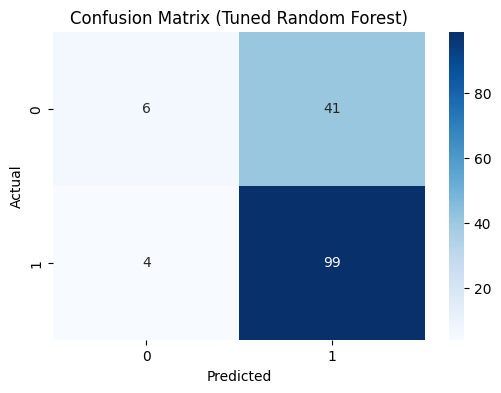

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract Best Model
rf_model = random_search_rf.best_estimator_

# Evaluate
val_preds_tuned = rf_model.predict(X_val)
tuned_f1 = f1_score(y_val, val_preds_tuned)
print(f"Tuned Model Validation F1 Score: {tuned_f1:.4f}")

# Visual Check
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, val_preds_tuned), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Tuned Random Forest)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ROC-AUC Score: 0.6567 (Higher is better)


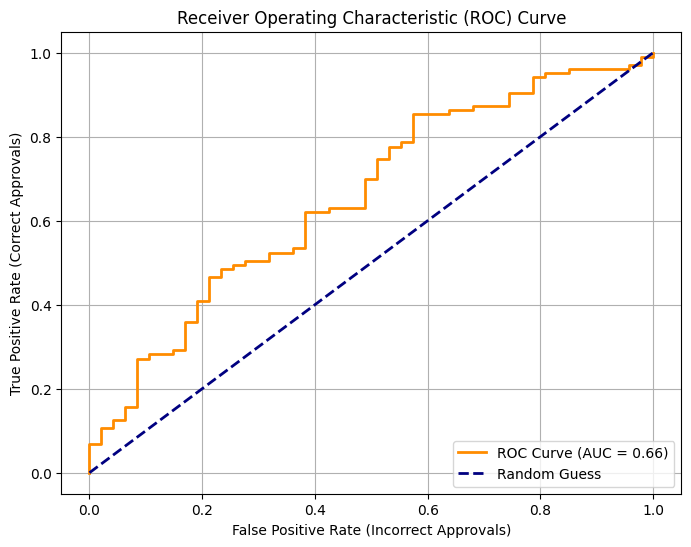

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probability Predictions
y_scores = rf_model.predict_proba(X_val)[:, 1]

# Calculate ROC Metrics
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
auc_score = roc_auc_score(y_val, y_scores)

print(f"ROC-AUC Score: {auc_score:.4f} (Higher is better)")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (Incorrect Approvals)')
plt.ylabel('True Positive Rate (Correct Approvals)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

results = []

for depth in [3, 4, 5, 6]:
    for leaf in [5, 10, 20]:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
        )
        dt.fit(X_train, y_train)
        val_pred = dt.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        
        results.append((depth, leaf, val_acc))

results_df = pd.DataFrame(
    results, columns=['max_depth', 'min_samples_leaf', 'val_accuracy']
)

results_df.sort_values(by='val_accuracy', ascending=False).head()


,max_depth,min_samples_leaf,val_accuracy
2,3,20,0.713333
4,4,10,0.713333
5,4,20,0.713333
1,3,10,0.706667
3,4,5,0.706667


In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=10,
    class_weight={0: 2, 1: 1},  # penalize false approvals
    random_state=42
)

dt_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 2, 1: 1}, max_depth=4,
                       min_samples_leaf=10, random_state=42)

In [25]:
from sklearn.metrics import accuracy_score

y_val_pred = dt_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", val_acc)


Validation Accuracy: 0.7333333333333333


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_test_pred, target_names=['Rejected', 'Approved']))


              precision    recall  f1-score   support

    Rejected       0.50      0.24      0.32        46
    Approved       0.73      0.89      0.80       104

    accuracy                           0.69       150
   macro avg       0.61      0.57      0.56       150
weighted avg       0.66      0.69      0.66       150



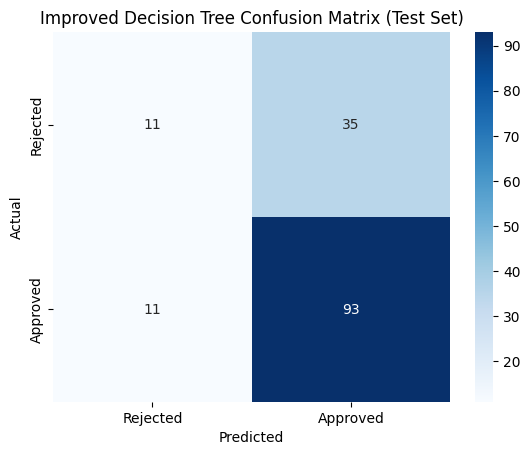

In [27]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])

plt.title("Improved Decision Tree Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


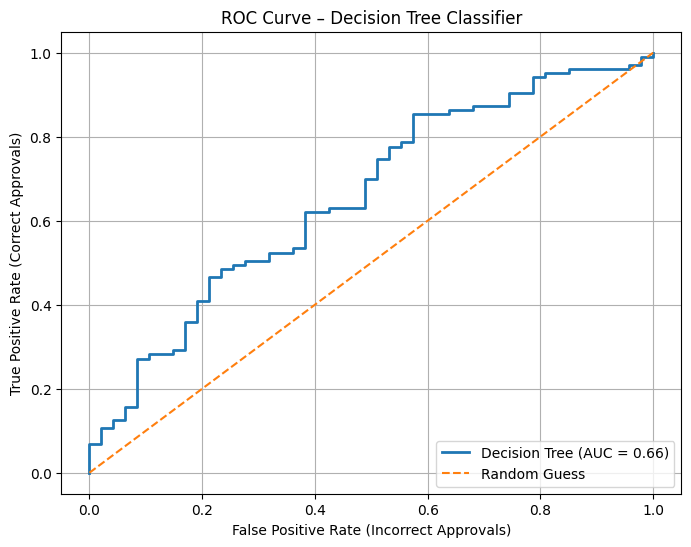

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'Decision Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate (Incorrect Approvals)')
plt.ylabel('True Positive Rate (Correct Approvals)')
plt.title('ROC Curve – Decision Tree Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Neural Network (Multi-Layer Perceptron)

In [30]:
!pip install optuna

In [32]:
!pip install imbalanced-learn

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ( classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score )

In [34]:
# Scaling to fit MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Apply smote to handle imbalance class
smote = SMOTETomek(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample( X_train_scaled, y_train )
print("After SMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts())

After SMOTE class distribution:
0    432
1    432
Name: count, dtype: int64


In [36]:
# optuna for hyperparameter tuning
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = [
        trial.suggest_int(f"n_units_l{i}", 16, 64)
        for i in range(n_layers)
    ]

    params = {
        "hidden_layer_sizes": tuple(layers),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "alpha": trial.suggest_float("alpha", 1e-2, 1e-1, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "max_iter": 2000,
        "early_stopping": True,
        "validation_fraction": 0.1,
        "random_state": 42
    }

    model = MLPClassifier(**params)
    model.fit(X_train_smote, y_train_smote)

    val_preds = model.predict(X_val_scaled)
    return f1_score(y_val, val_preds, average="macro")

In [37]:
print("\nStarting Optuna Study...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("\nBest Macro F1:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-01-06 17:29:56,707] A new study created in memory with name: no-name-782906d5-8252-49a0-936a-fbdc40da4354



Starting Optuna Study...


[I 2026-01-06 17:29:56,924] Trial 0 finished with value: 0.48389114795120425 and parameters: {'n_layers': 2, 'n_units_l0': 31, 'n_units_l1': 17, 'activation': 'tanh', 'alpha': 0.06285775218469662, 'learning_rate_init': 0.0007175931696327345}. Best is trial 0 with value: 0.48389114795120425.
[I 2026-01-06 17:29:57,088] Trial 1 finished with value: 0.5289244913749943 and parameters: {'n_layers': 2, 'n_units_l0': 45, 'n_units_l1': 50, 'activation': 'relu', 'alpha': 0.018958115966498833, 'learning_rate_init': 0.0004599806173081364}. Best is trial 1 with value: 0.5289244913749943.
[I 2026-01-06 17:29:57,167] Trial 2 finished with value: 0.23732506900392233 and parameters: {'n_layers': 2, 'n_units_l0': 51, 'n_units_l1': 23, 'activation': 'relu', 'alpha': 0.01585122150740827, 'learning_rate_init': 0.00013406786880128195}. Best is trial 1 with value: 0.5289244913749943.
[I 2026-01-06 17:29:57,497] Trial 3 finished with value: 0.5044642857142857 and parameters: {'n_layers': 2, 'n_units_l0': 37,


Best Macro F1: 0.5731946624803768
Best Params: {'n_layers': 1, 'n_units_l0': 19, 'activation': 'tanh', 'alpha': 0.013850781759521529, 'learning_rate_init': 0.00045470598663491083}


In [38]:
# train best model
best_params = study.best_params
best_layers = [
    best_params[f"n_units_l{i}"]
    for i in range(best_params["n_layers"])
]

mlp_model = MLPClassifier(
    hidden_layer_sizes=tuple(best_layers),
    activation=best_params["activation"],
    alpha=best_params["alpha"],
    learning_rate_init=best_params["learning_rate_init"],
    max_iter=2000,
    early_stopping=True,
    random_state=42
)

mlp_model.fit(X_train_smote, y_train_smote)

MLPClassifier(activation='tanh', alpha=0.013850781759521529,
              early_stopping=True, hidden_layer_sizes=(19,),
              learning_rate_init=0.00045470598663491083, max_iter=2000,
              random_state=42)

In [39]:
# Find best threshold
y_val_probs = mlp_model.predict_proba(X_val_scaled)[:, 1]

thresholds = np.linspace(0.2, 0.8, 61)
best_t, best_f1 = 0.5, 0

for t in thresholds:
    val_preds = (y_val_probs >= t).astype(int)
    f1 = f1_score(y_val, val_preds, average="macro")
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\nBest threshold from validation: {best_t:.2f}")
print(f"Best Val Macro F1: {best_f1:.4f}")


Best threshold from validation: 0.53
Best Val Macro F1: 0.5867


In [40]:
# Final Testing
y_test_probs = mlp_model.predict_proba(X_test_scaled)[:, 1]
y_test_preds = (y_test_probs >= best_t).astype(int)

print("\nFinal Test Report:")
print(classification_report(
    y_test,
    y_test_preds,
    target_names=["Rejected", "Approved"]
))


Final Test Report:
              precision    recall  f1-score   support

    Rejected       0.29      0.41      0.34        46
    Approved       0.68      0.55      0.61       104

    accuracy                           0.51       150
   macro avg       0.48      0.48      0.47       150
weighted avg       0.56      0.51      0.52       150



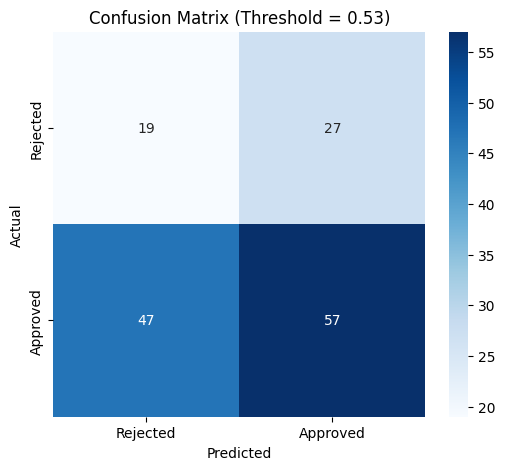

In [41]:
# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_test_preds),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"]
)
plt.title(f"Confusion Matrix (Threshold = {best_t:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

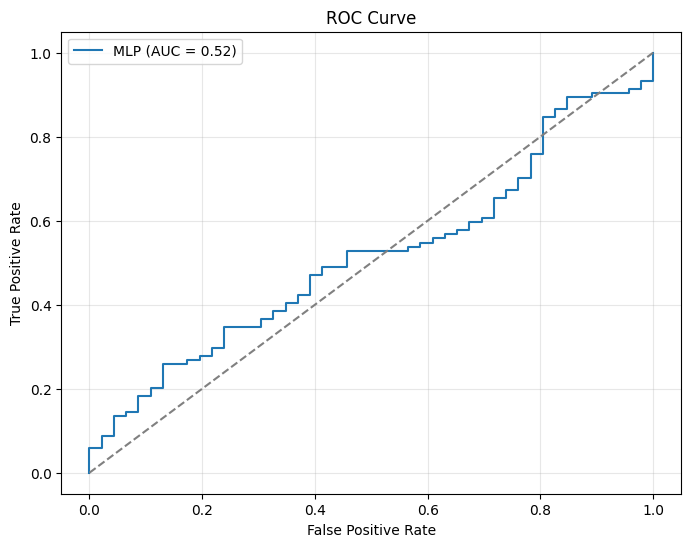

In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
auc_score = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Evaluation and Interpretation

In [44]:
!pip install shap

   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 14.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ------------ --------------------------- 12.3/38.1 MB 59.1 MB/s eta 0:00:01
   ------------------------------ --------- 29.1/38.1 MB 70.8 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.1 MB 73.2 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.1 MB 73.2 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 43.3 MB/s eta 0:00:00


In [48]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive evaluation function for a single model
    """
    # Use scaled data for Neural Network, regular data for others
    X_test_used = X_test_scaled if model_name == "Neural Network" else X_test
    
    # Get predictions
    y_pred = model.predict(X_test_used)
    y_pred_proba = model.predict_proba(X_test_used)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Add ROC-AUC if probability predictions available
    if y_pred_proba is not None:
        try:
            metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)
        except:
            metrics['ROC-AUC'] = np.nan
    else:
        metrics['ROC-AUC'] = np.nan
    
    return metrics, y_pred, y_pred_proba

# Evaluate all models
print("EVALUATING ALL MODELS")

results = []
predictions = {}
probabilities = {}

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Neural Network": mlp_model
}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    metrics, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, model_name)
    results.append(metrics)
    predictions[model_name] = y_pred
    probabilities[model_name] = y_pred_proba
    print(f"   ✓ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"   ✓ F1-Score: {metrics['F1-Score']:.4f}")
    print(f"   ✓ ROC-AUC: {metrics['ROC-AUC']:.4f}" if not np.isnan(metrics['ROC-AUC']) else "   ✓ ROC-AUC: N/A")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))
print()


EVALUATING ALL MODELS

Evaluating Logistic Regression...
   ✓ Accuracy: 0.6933
   ✓ F1-Score: 0.5678
   ✓ ROC-AUC: 0.4760

Evaluating Random Forest...
   ✓ Accuracy: 0.6867
   ✓ F1-Score: 0.6205
   ✓ ROC-AUC: 0.5345

Evaluating Decision Tree...
   ✓ Accuracy: 0.6933
   ✓ F1-Score: 0.6551
   ✓ ROC-AUC: 0.5964

Evaluating Neural Network...
   ✓ Accuracy: 0.5067
   ✓ F1-Score: 0.5184
   ✓ ROC-AUC: 0.5157

MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.6933     0.4807  0.6933    0.5678   0.4760
      Random Forest    0.6867     0.6324  0.6867    0.6205   0.5345
      Decision Tree    0.6933     0.6571  0.6933    0.6551   0.5964
     Neural Network    0.5067     0.5340  0.5067    0.5184   0.5157




Creating Model Comparison Dashboard...


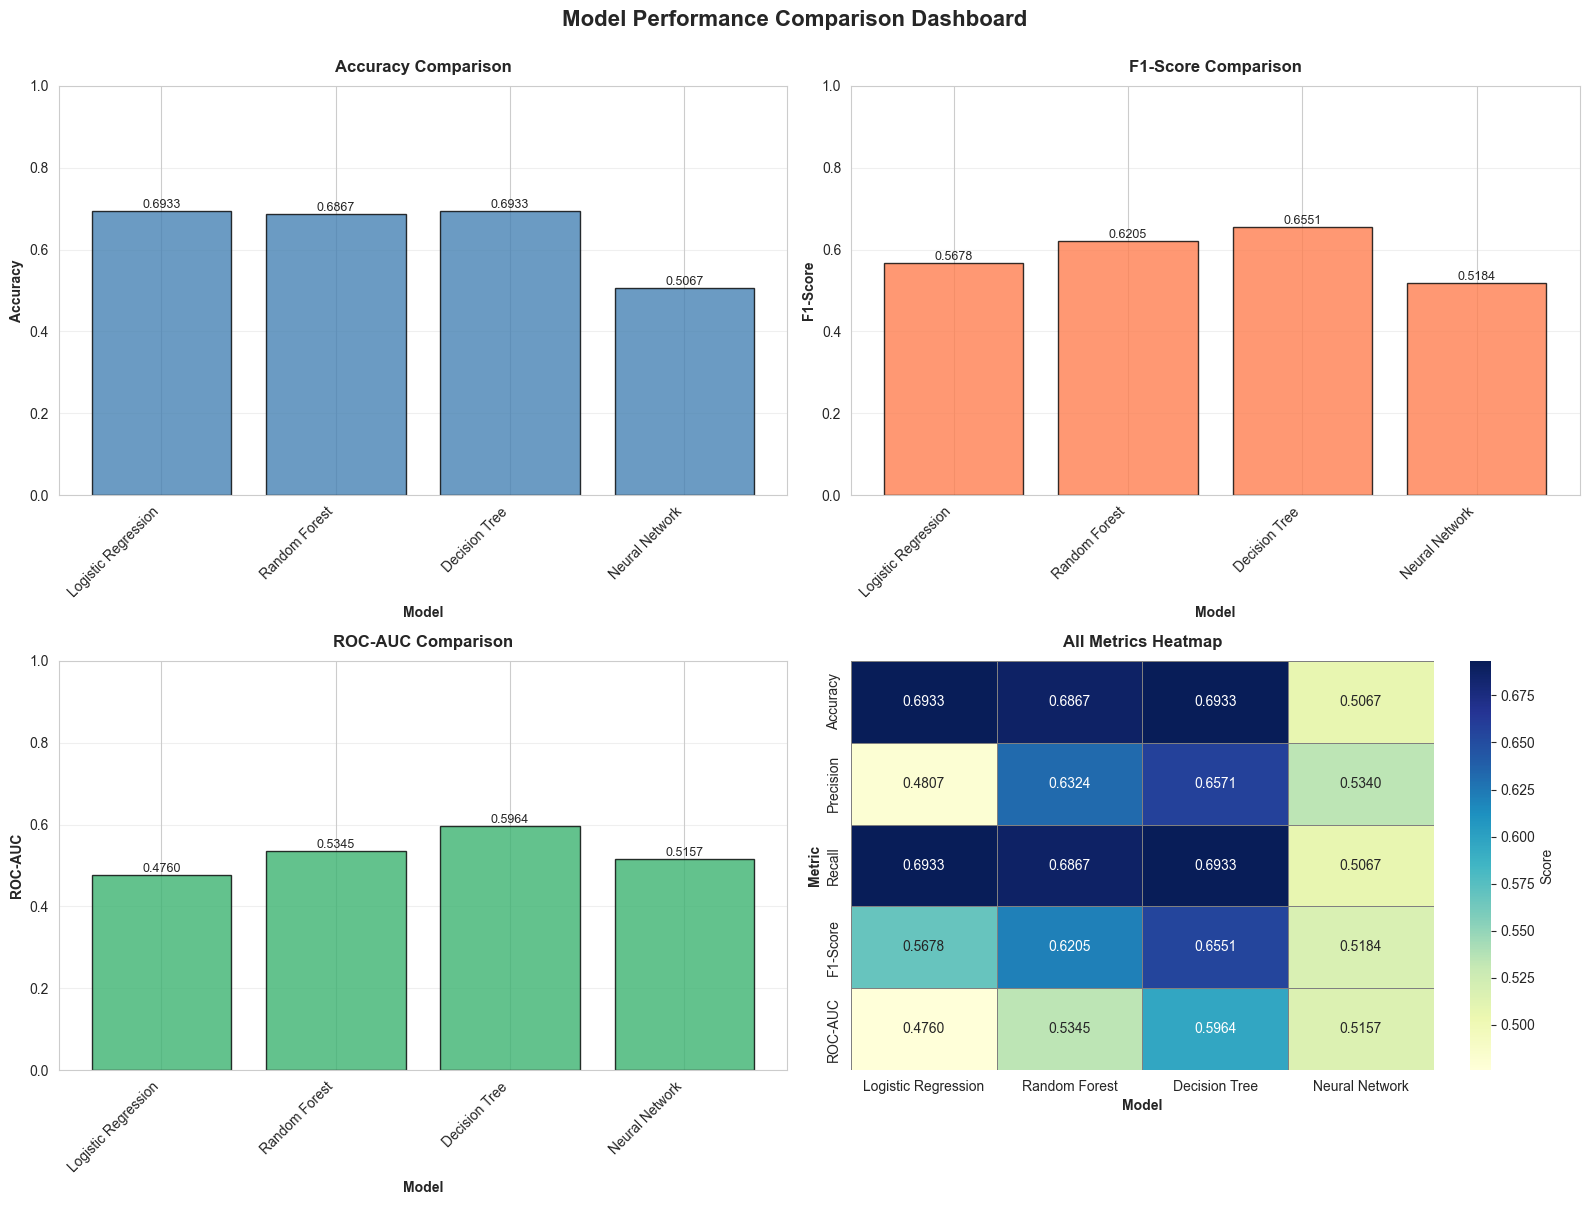

In [49]:
# =============================================================================
#  Model Comparison Dashboard
# =============================================================================

print("\nCreating Model Comparison Dashboard...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Dashboard', fontsize=16, fontweight='bold', y=1.00)

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(results_df['Model'], results_df['Accuracy'], color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy Comparison', fontweight='bold', pad=10)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: F1-Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['Model'], results_df['F1-Score'], color='coral', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score Comparison', fontweight='bold', pad=10)
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: ROC-AUC Comparison
ax3 = axes[1, 0]
roc_data = results_df[results_df['ROC-AUC'].notna()]
if len(roc_data) > 0:
    bars3 = ax3.bar(roc_data['Model'], roc_data['ROC-AUC'], color='mediumseagreen', alpha=0.8, edgecolor='black')
    ax3.set_xlabel('Model', fontweight='bold')
    ax3.set_ylabel('ROC-AUC', fontweight='bold')
    ax3.set_title('ROC-AUC Comparison', fontweight='bold', pad=10)
    ax3.set_ylim([0, 1.0])
    ax3.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax3.text(0.5, 0.5, 'No ROC-AUC Data Available', ha='center', va='center', fontsize=12)

# Plot 4: All Metrics Heatmap
ax4 = axes[1, 1]
metrics_for_heatmap = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
sns.heatmap(metrics_for_heatmap.T, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, ax=ax4, linewidths=0.5, linecolor='gray')
ax4.set_title('All Metrics Heatmap', fontweight='bold', pad=10)
ax4.set_xlabel('Model', fontweight='bold')
ax4.set_ylabel('Metric', fontweight='bold')

plt.tight_layout()
plt.show()



 Creating Confusion Matrices...


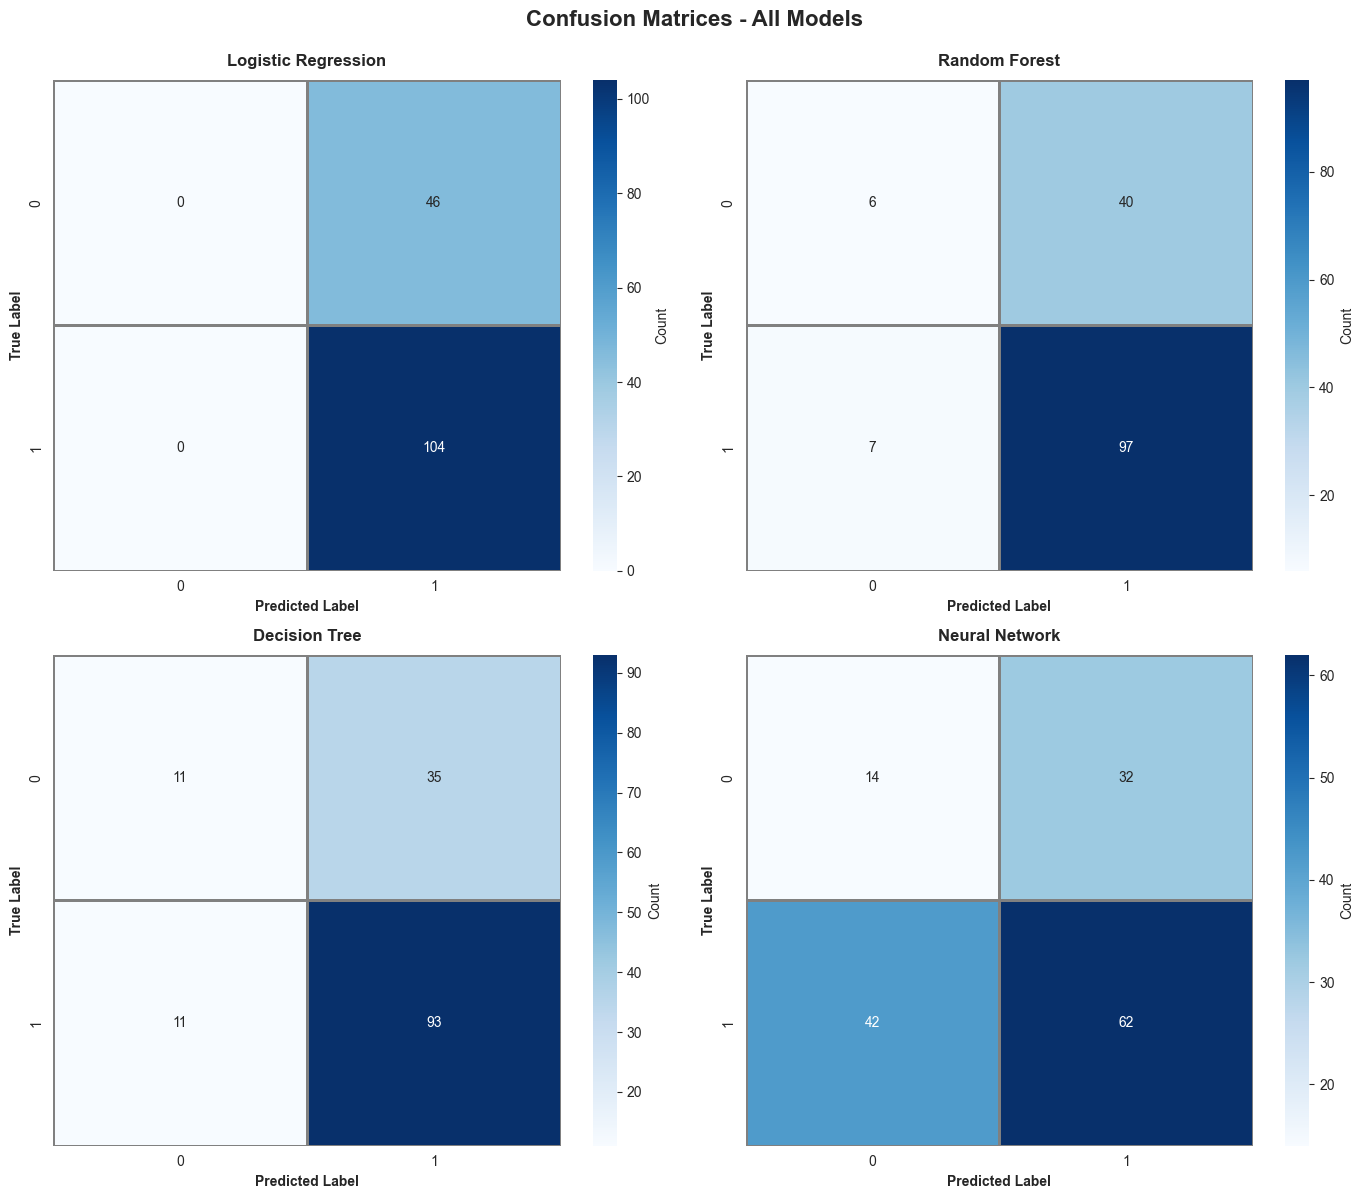


 Creating ROC Curves...


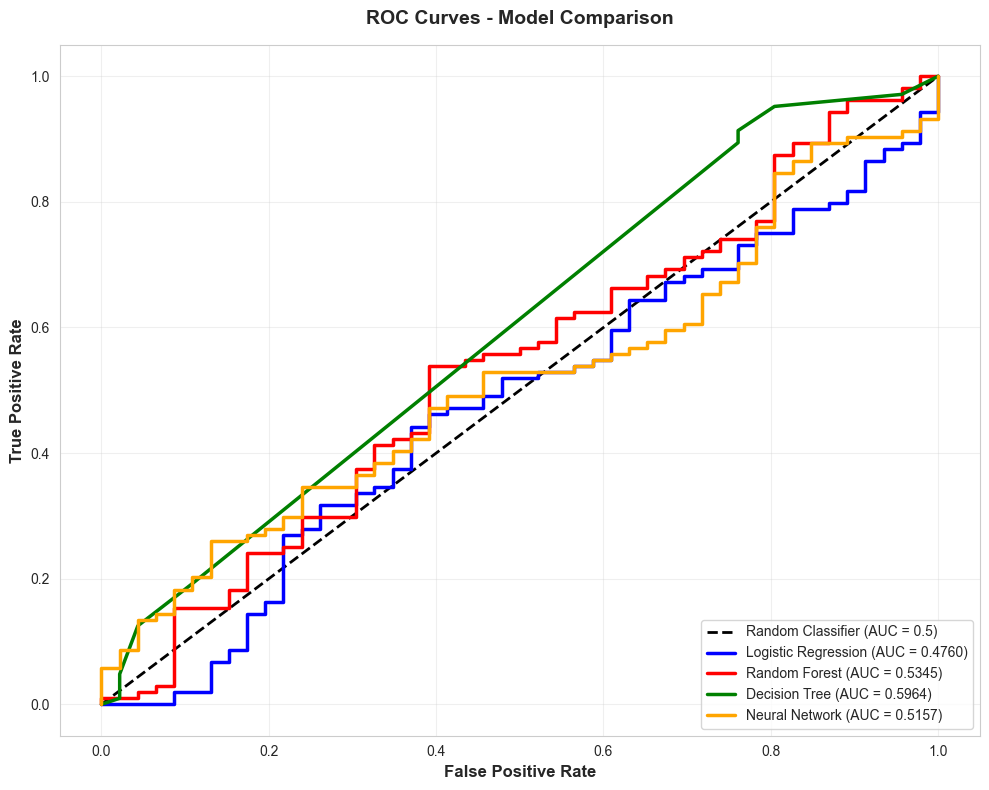

In [50]:
# =============================================================================
# SECTION 5.3: Confusion Matrices for All Models
# =============================================================================

print("\n Creating Confusion Matrices...")

n_models = len(models)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Count'}, linewidths=1, linecolor='gray')
    axes[idx].set_title(f'{model_name}', fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# SECTION 5.4: ROC Curves for All Models
# =============================================================================

print("\n Creating ROC Curves...")

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)

colors = ['blue', 'red', 'green', 'orange']
for idx, (model_name, y_pred_proba) in enumerate(probabilities.items()):
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[idx], linewidth=2.5, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [55]:
# =============================================================================
# SECTION 5.5: Detailed Classification Reports
# =============================================================================

print("DETAILED CLASSIFICATION REPORTS")

for model_name, y_pred in predictions.items():
    print(f"\n{'='*80}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*80}")
    print(classification_report(y_test, y_pred, zero_division=0))


DETAILED CLASSIFICATION REPORTS

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.69      1.00      0.82       104

    accuracy                           0.69       150
   macro avg       0.35      0.50      0.41       150
weighted avg       0.48      0.69      0.57       150


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.46      0.13      0.20        46
           1       0.71      0.93      0.80       104

    accuracy                           0.69       150
   macro avg       0.58      0.53      0.50       150
weighted avg       0.63      0.69      0.62       150


Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        46
           1       0.73      0.89      0.80       104

    accuracy               

In [57]:
# =============================================================================
# SECTION 5.6: Identify Best Model
# =============================================================================
print("\nBEST MODEL SELECTION")
# Find best model based on different metrics
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
best_roc_auc = results_df.loc[results_df['ROC-AUC'].idxmax()] if results_df['ROC-AUC'].notna().any() else None

print(f"\n Best Model by Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
print(f" Best Model by F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
if best_roc_auc is not None:
    print(f" Best Model by ROC-AUC: {best_roc_auc['Model']} ({best_roc_auc['ROC-AUC']:.4f})")

# Overall best model (based on F1-Score as primary metric)
best_model_name = best_f1['Model']
print(f"\n OVERALL BEST MODEL: {best_model_name}")
print(f"   Justification: Highest F1-Score ({best_f1['F1-Score']:.4f}), which balances precision and recall.")


BEST MODEL SELECTION

 Best Model by Accuracy: Logistic Regression (0.6933)
 Best Model by F1-Score: Decision Tree (0.6551)
 Best Model by ROC-AUC: Decision Tree (0.5964)

 OVERALL BEST MODEL: Decision Tree
   Justification: Highest F1-Score (0.6551), which balances precision and recall.
